In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datacleaner import autoclean
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from pprint import pprint
from scipy.stats import uniform

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.model_selection import validation_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, auc, log_loss
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, CondensedNearestNeighbour

from sklearn.feature_selection import chi2, f_classif, f_regression, SelectKBest
from sklearn.inspection import permutation_importance

### Functions

In [2]:
def timer(start_time=None):
    """Timer to measure working time of the algorithm"""
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, time_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(time_sec, 60)
        print("Time taken: %i hours %i minutes %s seconds" % (thour, tmin, round(tsec, 2)))

def get_estimator(model, grid):
    """Function to select the best estimator using Random search CV"""
    # Random cross validation for Hyperparameter tuning
    x_random = RandomizedSearchCV(
        estimator=model, param_distributions=grid, n_iter=5, n_jobs=-1, scoring='neg_log_loss', cv=5, verbose=2, random_state=33
    )
    
    start_time = timer(None) # Timing starts from this point for \"start_time\" variable
    x_random.fit(X_train, y_train)
    timer(start_time) # timing ends here for \"start_time\" variable"

    return x_random.best_estimator_

In [3]:
def encode_LE(data, cols, verbose=True):
    """Function to Encode Data"""
    for col in cols:
        data[col], unique = pd.factorize(data[col], sort=True)

In [4]:
def age_group(data, col):
    """Function to create new feature age group"""
    group = []
    cat = None
    for age in data[col]:
        if (age > 0) & (age <= 30):
            cat = 'young'
            group.append(cat)
        if (age > 30) & (age <= 60):
            cat = 'adult'
            group.append(cat)
        if (age > 60) & (age < 100):
            cat = 'elder'
            group.append(cat)
    
    return group

In [5]:
def get_output(data, clf, name):
    """Function to make predictions and store it into a csv file"""
    x = {
            'ID X PCODE': data['ID X PCODE']
        }

    # Prediction
    y_pred = clf.predict(X_true)

    x['Label'] = y_pred

    output = pd.DataFrame(x)

    output.reset_index(drop=True, inplace=True)

    return output.to_csv(name, index=False)

# A. Training Set

### 1. Load Data

In [6]:
print("*"*45, "Train set", "*"*45)
df = pd.read_csv(r"/home/praveen/Downloads/Data Science/Data projects/Insurance/file/Train.csv")

df.fillna(method='ffill', inplace=True)

df.sample(5).T

********************************************* Train set *********************************************


,4500,14466,1205,6588,28054
ID,UK8TD35,LEM3PTZ,IFRTZM0,PHQ58UQ,MSFKKH5
join_date,1/12/2018,1/10/2016,1/2/2016,1/8/2013,1/4/2018
sex,M,F,M,M,M
marital_status,M,U,M,U,M
birth_year,1981,1975,1972,1973,1977
branch_code,UAOD,748L,ZFER,748L,UAOD
occupation_code,I31I,0OJM,0KID,0OJM,SST3
occupation_category_code,T4MS,T4MS,T4MS,T4MS,56SI
P5DA,0,0,0,0,0
RIBP,0,1,0,0,0


### 2. Restructure Data

In [7]:
# Products in the df
products = df[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
            'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

# Number of products
nop = products.shape[1]

pro_cols = products.columns.tolist()

# Products bought feature
df['products_bought'] = df[pro_cols].sum(axis=1, skipna=True)

# Probability of products
df['prob_of_products'] = df['products_bought']/21

# Age feature in years
df['Age'] = 2020 - df['birth_year']
    
# Age Group of customers
df['age_group'] = age_group(df, 'Age')

# Retention time in days
df['join_date'] = df['join_date'].apply(lambda x: datetime.strptime(str(x), "%d/%m/%Y"))

df['retention_time(days)'] = (datetime(2020,7,23) - df['join_date']).dt.days
    
# Retention time in years
df['retention_time(years)'] = df['retention_time(days)']/365

# Average Product bought
df['avg_products_bought'] = df['products_bought']/df['retention_time(years)']

# Alligning features
df = df[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
        'occupation_code', 'occupation_category_code', 'Age', 'age_group', 'retention_time(days)',
        'retention_time(years)', 'avg_products_bought', 'prob_of_products',
        'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR','SOP4', 'RVSZ',
        'PYUQ','LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL',
        'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]


#### Target Variable

In [8]:
# Assigning labels by sampling
products = df[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
                 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
    
df = df.melt(
    id_vars = df.columns[:14], value_vars=products, var_name='PCODE', value_name='Label'
)

df['X'] = ' X '

# Combining Unique ID with code
df['ID X PCODE'] = df['ID'] + df['X'] + df['PCODE']

#Re-arrange columns
df = df[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'Age', 'age_group',
        'retention_time(days)', 'retention_time(years)', 'occupation_code', 'avg_products_bought',
        'prob_of_products', 'occupation_category_code', 'PCODE', 'ID X PCODE', 'Label']]

df.head(5)

,ID,join_date,sex,marital_status,birth_year,branch_code,Age,age_group,retention_time(days),retention_time(years),occupation_code,avg_products_bought,prob_of_products,occupation_category_code,PCODE,ID X PCODE,Label
0,4WKQSBB,2019-02-01,F,M,1987,1X1H,33,adult,538,1.473973,2A7I,1.356877,0.095238,T4MS,P5DA,4WKQSBB X P5DA,0
1,CP5S02H,2019-06-01,F,M,1981,UAOD,39,adult,418,1.145205,2A7I,1.746411,0.095238,T4MS,P5DA,CP5S02H X P5DA,0
2,2YKDILJ,2013-06-01,M,U,1991,748L,29,young,2609,7.147945,QZYX,0.419701,0.142857,90QI,P5DA,2YKDILJ X P5DA,0
3,2S9E81J,2019-08-01,M,M,1990,1X1H,30,young,357,0.978082,BP09,2.044818,0.095238,56SI,P5DA,2S9E81J X P5DA,0
4,BHDYVFT,2019-08-01,M,M,1990,748L,30,young,357,0.978082,NO3L,2.044818,0.095238,T4MS,P5DA,BHDYVFT X P5DA,0


### 3. Base Model

#### 3.1 Split Data

In [9]:
X = df.drop(['Label', 'ID', 'retention_time(years)', 'join_date', 'birth_year', 'ID X PCODE'], axis=1)

y = df['Label'].copy()
    
clean_X = autoclean(X)
    
X_train, X_val, y_train, y_val = train_test_split(clean_X, y, test_size=0.3, random_state=7)

#### 3.2 Base Model Evaluation

In [10]:
# Classifier
base_clf = GradientBoostingClassifier().fit(X_train, y_train)
    
# Predictions
y_pred = base_clf.predict(X_val)
    
print(classification_report(y_val, y_pred))
    
x = {
    'train score': round(base_clf.score(X_train, y_train), 2), # Training Accuracy
    'test score': round(base_clf.score(X_val, y_val), 2), # Testing Accuracy
    'ROC AUC score': round(roc_auc_score(y_val, y_pred), 2), # ROC AUC Score
    'log loss': round(log_loss(y_val, y_pred), 2) # Log Loss Score
} 

print(x)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    163502
           1       0.83      0.77      0.80     20030

    accuracy                           0.96    183532
   macro avg       0.90      0.88      0.89    183532
weighted avg       0.96      0.96      0.96    183532

{'train score': 0.96, 'test score': 0.96, 'ROC AUC score': 0.88, 'log loss': 1.47}


### 4. Feature Significance

Feature Importance using f score :
                       feature  importance
0                      PCODE        1488
3       retention_time(days)         759
6                branch_code         600
7            occupation_code         548
5                        Age         542
2        avg_products_bought         518
1           prob_of_products         291
4             marital_status         257
9   occupation_category_code          96
8                        sex          66
10                 age_group          12
--------------------------------------------------


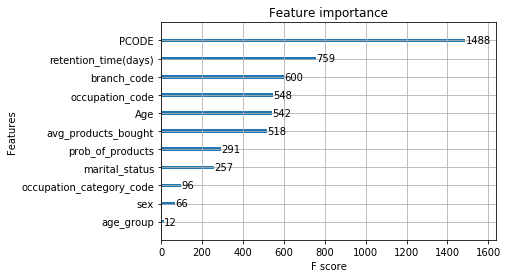

--------------------------------------------------
Feature importance using xgboost :
Feature: 0, Score: 0.01686
Feature: 1, Score: 0.08705
Feature: 2, Score: 0.08086
Feature: 3, Score: 0.01737
Feature: 4, Score: 0.01022
Feature: 5, Score: 0.09771
Feature: 6, Score: 0.02520
Feature: 7, Score: 0.04384
Feature: 8, Score: 0.13136
Feature: 9, Score: 0.02413
Feature: 10, Score: 0.46540
--------------------------------------------------


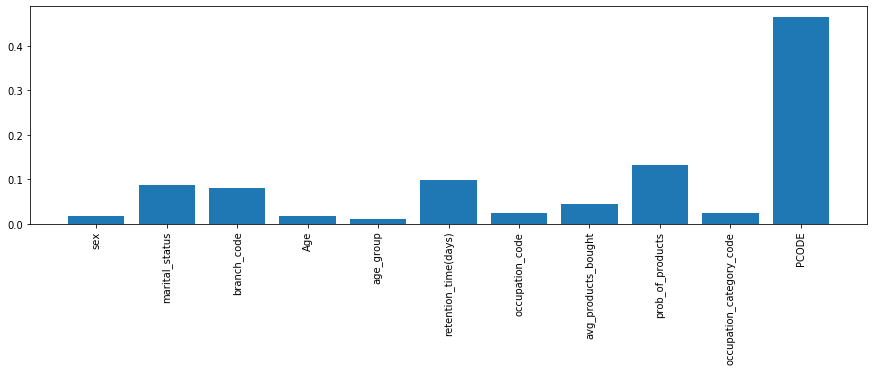

--------------------------------------------------
Feature importance using permutation :
Feature: 0, Score: 0.00044
Feature: 1, Score: 0.01041
Feature: 2, Score: 0.02847
Feature: 3, Score: 0.00532
Feature: 4, Score: 0.00008
Feature: 5, Score: 0.03322
Feature: 6, Score: 0.00643
Feature: 7, Score: 0.00808
Feature: 8, Score: 0.02659
Feature: 9, Score: 0.00161
Feature: 10, Score: 0.71318
--------------------------------------------------


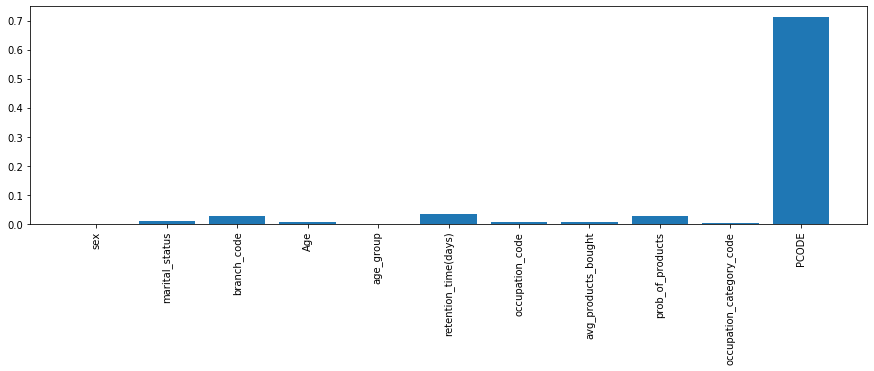

In [11]:
cols = X.columns.tolist()

encode_LE(X,['sex', 'marital_status', 'branch_code', 'occupation_category_code', 'PCODE', 'occupation_code',
             'age_group'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=33)

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

# perform xgb importance
xgb_fea_imp = pd.DataFrame(list(xgb.get_booster().get_fscore().items()), 
                        columns=['feature','importance']).sort_values('importance', ascending=False)

# get xgb importance
xgb_sig = xgb.feature_importances_

# perform permutation importance
results = permutation_importance(xgb, X, y, scoring='neg_log_loss')

# get permutation importance
importance = results.importances_mean

# List of feature f score
print('Feature Importance using f score :\n', '', xgb_fea_imp)
print('-'*50)

# Plot feature f score
plot_importance(xgb, )
plt.show()
print('-'*50)

# Summarize feature importance
print('Feature importance using xgboost :')
for i,v in enumerate(xgb_sig):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('-'*50)

# plot xgb feature importance
plt.figure(figsize=[15, 4])
plt.bar([x for x in cols], xgb_sig)
plt.xticks(rotation=90)
plt.show()
print('-'*50)

# Summarize feature importance
print('Feature importance using permutation :')
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('-'*50)

# plot permutation feature importance
plt.figure(figsize=[15, 4])
plt.bar([x for x in cols], importance)
plt.xticks(rotation=90)
plt.show()


#### Feature Selection

The Following columns will be dropped -

- join_date 
- birth_year
- retention_time(days)
- Age

#### Split Data

In [12]:
X_fs = df.drop(['Label', 'ID', 'ID X PCODE', 'join_date', 'birth_year', 'retention_time(days)', 'Age'], axis=1)
y_fs = df['Label'].copy()

encode_LE(X_fs,['sex', 'marital_status', 'branch_code', 'occupation_category_code', 'PCODE', 'occupation_code',
             'age_group'])

# Train and Validation set
X_train, X_val, y_train, y_val = train_test_split(X_fs, y_fs, test_size=0.3, random_state=33)

### 5. Hyperparameter Tuning

#### Grid

In [13]:
# Number of trees in the model
max_iters = [int(x) for x in np.arange(1000, 2000, 200)]

# Learning rate in XGBClassifier
learning_rate = [round(x, 2) for x in np.arange(0.05, 0.3, 0.05)]

# Number of trees in the model
n_estimators = [int(x) for x in np.arange(100, 300, 50)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(9, 35, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
gb_grid = {'learning_rate': learning_rate,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
            'min_samples_leaf': list(np.arange(1,7)),
            'max_leaf_nodes': list(np.arange(2,11,2))}

print("Grid for Hyperparameter tuning :\n", gb_grid)
print('-'*100)

Grid for Hyperparameter tuning :
 {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25], 'n_estimators': [100, 150, 200, 250], 'max_depth': [9, 11, 14, 16, 19, 22, 24, 27, 29, 32, 35, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_leaf_nodes': [2, 4, 6, 8, 10]}
----------------------------------------------------------------------------------------------------


#### Tuned Model Evaluation

In [14]:
gb_imb = get_estimator(GradientBoostingClassifier(), gb_grid)

print('Best Estimator :\n', gb_imb)
print('-'*100)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.1min finished


Time taken: 0 hours 24 minutes 7.39 seconds
Best Estimator :
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=32,
                           max_features=None, max_leaf_nodes=10,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=6, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
----------------------------------------------------------------------------------------------------


In [15]:
# Fit model on train set
gb_imb.fit(X_train, y_train)

# Predictions
y_pred = gb_imb.predict(X_val)
    
print(classification_report(y_val, y_pred))
    
x = {
    'train score': round(gb_imb.score(X_train, y_train), 2), # Training Accuracy
    'test score': round(gb_imb.score(X_val, y_val), 2), # Testing Accuracy 
    'ROC AUC Score': round(roc_auc_score(y_val, y_pred), 2), # ROC AUC Score
    'log loss': round(log_loss(y_val, y_pred), 2) # Log Loss Score
}

print(x)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    163557
           1       0.86      0.81      0.83     19975

    accuracy                           0.96    183532
   macro avg       0.92      0.90      0.91    183532
weighted avg       0.96      0.96      0.96    183532

{'train score': 0.97, 'test score': 0.96, 'ROC AUC Score': 0.9, 'log loss': 1.21}


# B. Test Set

### 1. Load Dataset

In [16]:
### B. Testing set
print("*"*45, "Test set", "*"*45)
test = pd.read_csv(r"/home/praveen/Downloads/Data Science/Data projects/Insurance/file/Test.csv")

# Filling NaN values
test.fillna(method='ffill', inplace=True)

********************************************* Test set *********************************************


### 2. Restructure Data

In [17]:
# Products in the test
products = test[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
            'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

# Products bought feature
test['products_bought'] = test[pro_cols].sum(axis=1, skipna=True)

# Probability of products
test['prob_of_products'] = test['products_bought']/21

# Age feature in years
test['Age'] = 2020 - test['birth_year']
    
# Age Group of customers
test['age_group'] = age_group(test, 'Age')

# Retention time in days
test['join_date'] = test['join_date'].apply(lambda x: datetime.strptime(str(x), "%d/%m/%Y"))

test['retention_time(days)'] = (datetime(2020,7,23) - test['join_date']).dt.days
    
# Retention time in years
test['retention_time(years)'] = test['retention_time(days)']/365

# Average Product bought
test['avg_products_bought'] = test['products_bought']/test['retention_time(years)']

# Alligning features
test = test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
        'occupation_code', 'occupation_category_code', 'Age', 'age_group', 'retention_time(days)',
        'retention_time(years)', 'avg_products_bought', 'prob_of_products',
        'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR','SOP4', 'RVSZ',
        'PYUQ','LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL',
        'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]


#### Target Variable

In [18]:
# Assigning labels by sampling
products = test[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
                 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
    
test = test.melt(
    id_vars = test.columns[:14], value_vars=products, var_name='PCODE', value_name='Label'
)

test['X'] = ' X '

# Combining Unique ID with code
test['ID X PCODE'] = test['ID'] + test['X'] + test['PCODE']

#Re-arrange columns
test = test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'Age', 'age_group',
        'retention_time(days)', 'retention_time(years)', 'occupation_code', 'avg_products_bought',
        'prob_of_products', 'occupation_category_code', 'PCODE', 'ID X PCODE', 'Label']]


#### Feature Engineering

In [23]:
X_true = test.drop(['Label', 'ID', 'ID X PCODE', 'join_date', 'birth_year', 'retention_time(days)', 'Age'], axis=1)

encode_LE(X_true,['sex', 'marital_status', 'branch_code', 'occupation_category_code', 'PCODE', 'occupation_code',
             'age_group'])

#### Output

In [25]:
get_output(
    test, gb_imb, 'gb_imb_output.csv')